In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

%matplotlib inline
sns.set_style("darkgrid")

from randomForest import random_forest_algorithm,random_forest_predictions 
from utils import predict_example,r_squared

In [2]:
df = pd.read_csv("./data/bike_sharing_daily.csv", parse_dates=["dteday"])

In [3]:
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

In [4]:
df.head()

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [5]:
date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

In [6]:
df["label"] = df.cnt
df = df.drop("cnt", axis=1)

In [36]:
train_df = df.iloc[:-122]
val_df = df.iloc[-122:-61]  # Sep and Oct of 2012
test_df = df.iloc[-61:]

In [43]:
grid_search = {"max_depth": [], 
               "min_samples": [],
               "n_features":[],
               "r_squared_train": [], 
               "r_squared_val": []}
for max_depth in range(1, 7):
    for min_samples in range(5, 20, 5):
        for n_features in (2,9):
            forest = random_forest_algorithm(train_df, 
                                           ml_task="regression",
                                           n_trees=4, 
                                           n_bootstrap=650,
                                           n_features=n_features,
                                           dt_max_depth=max_depth, 
                                           min_samples=min_samples)
            
            predictions_train = random_forest_predictions(train_df, forest)
            predictions_val = random_forest_predictions(val_df, forest)

            r_squared_train = r_squared(predictions_train, train_df.label)
            r_squared_val = r_squared(predictions_val, val_df.label)

            grid_search["max_depth"].append(max_depth)
            grid_search["min_samples"].append(min_samples)
            grid_search["n_features"].append(n_features)
            grid_search["r_squared_train"].append(r_squared_train)
            grid_search["r_squared_val"].append(r_squared_val)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,n_features,r_squared_train,r_squared_val
31,6,5,9,0.926109,0.412013
25,5,5,9,0.896217,0.340567
17,3,15,9,0.834666,0.151495
23,4,15,9,0.862031,0.118811
13,3,5,9,0.814806,0.051977


In [44]:
best_max_depth = 6
best_min_samples = 5
best_n_features = 9

forest = random_forest_algorithm(train_df, 
                                 ml_task="regression",
                                 n_trees=4, 
                                 n_bootstrap=650,
                                 min_samples=best_min_samples,
                                 n_features=best_n_features, 
                                 dt_max_depth=best_max_depth)
predictions = random_forest_predictions(test_df, forest)

In [45]:
r_squared_test = r_squared(predictions, test_df.label)

print("r_squared = {}".format(r_squared_test))

r_squared = 0.46535435961037863


In [49]:
def create_plot(df, forest, title):    
    predictions = random_forest_predictions(df, forest)
    actual = df.label
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

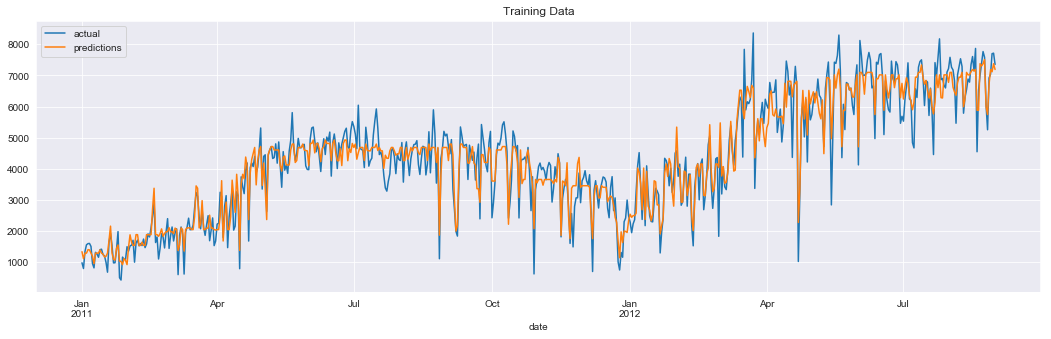

In [50]:
create_plot(train_df, forest, title="Training Data")

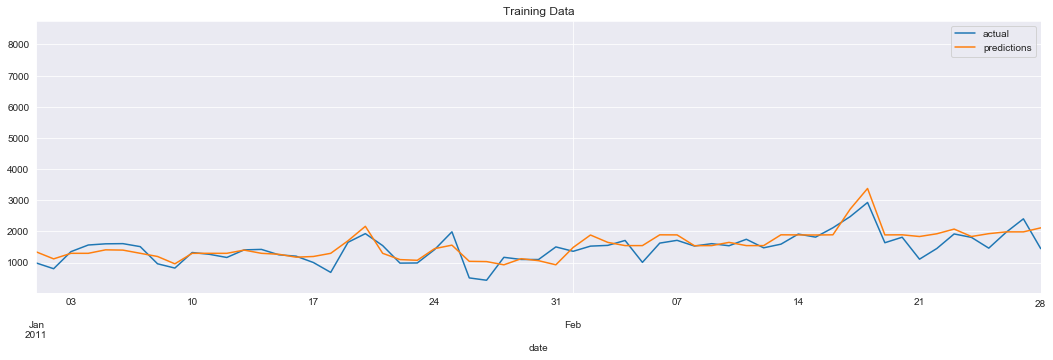

In [51]:
create_plot(train_df, forest, title="Training Data")
plt.xlim(pd.to_datetime("2011-01-01"), pd.to_datetime("2011-02-28"));

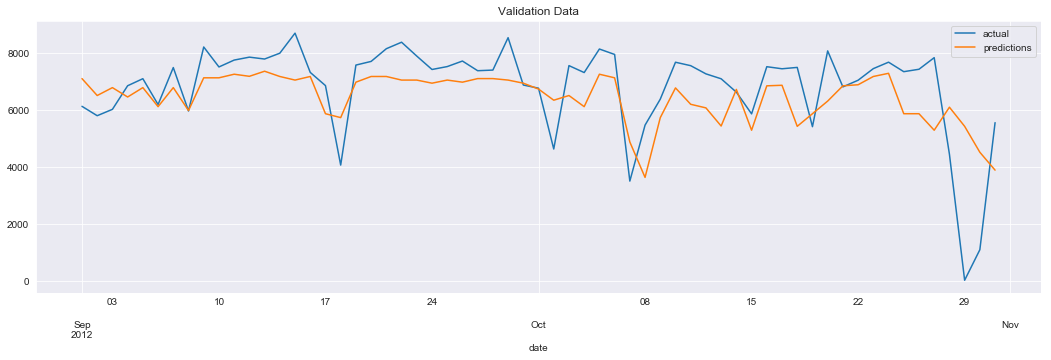

In [52]:
create_plot(val_df, forest, title="Validation Data")

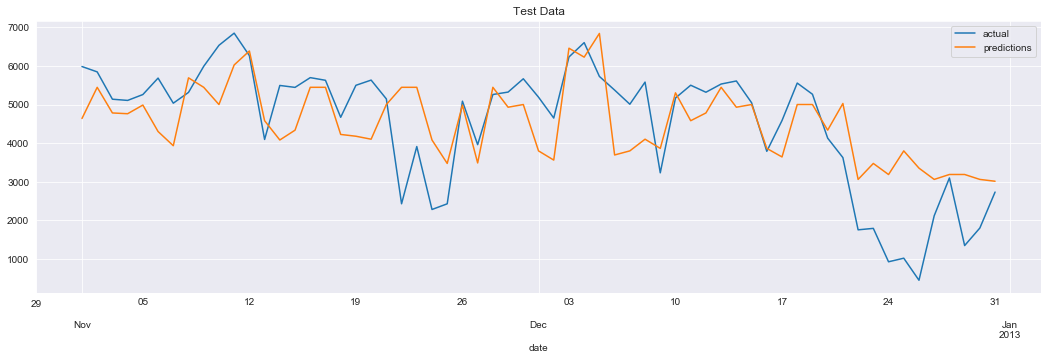

In [53]:
create_plot(test_df, forest, title="Test Data")